# Install and import beautifulsoup and pandas if they are not already installed

In [279]:
# Check if beautifulsoup and pandas are already installed
# If not, install it and then import

try:
    from bs4 import BeautifulSoup
    import pandas as pd
    from matplotlib import pyplot as plt
    print ("BeautifulSoup and Pandas are already installed and imported")
except:
    import sys
    !conda install --yes --prefix {sys.prefix} bs4
    !conda install --yes --prefix {sys.prefix} pandas
    !conda install --yes --prefix {sys.prefix} matplotlib
    from bs4 import BeautifulSoup
    import pandas
    print ("BeautifulSoup and Pandas were not found. Installed them and imported")

import requests

BeautifulSoup and Pandas are already installed and imported


# Open, Extract, and Clean data from a webpage

The function first opens the webpage that I am going to work with, in this case I am going to clean the data for the top 300 anime based on the My Anime List(MAL) ranking

Then the code extracts data of interest and adds it to the raw_data list

After getting the raw data, the data needs to be cleaned.

This data has 11 diferent categories:
Rank, Anime name, Number of episodes, Air date, Members in that anime, Manga Store (a button), volume number, price of volume, Anime score, N/A (Score a user gives, linked ot their account) and Add to list (a button)

From these 11 categories, only the Rank, Anime name, Number of episodes, Air date, Members that watched the anime, and Anime score were important.

In the raw data, there is extranious \n which, when spliting raw data by '\n', would result in extranious spaces. In order to clean this, and remove any categories, a new list is created.

With a cleaned raw_data list, which I called entries, I checked specific cases to see under which category the data was in, appended the data to a dict, and appended that dict to a final_data list.

In [395]:
def cleaned_data(webpage):
    opened_webpage = requests.get(webpage)
    #print ("Webpage opened successfully...")

    # Initialize a BeautifulSoup object to read and parse the webpage read
    # This is like calling the __init__ function in BeautifulSoup
    bs = BeautifulSoup(opened_webpage.content, "html.parser")
    #print ("Webpage loaded and parsed successfully...")
    
    # Define an empty list where the data will be kept
    raw_data = []

    # Find all the tables in the webpage page that we have just parsed
    table = bs.find_all("table")

    for row in table:
        line = row.text
        raw_data.append(line)
    
    dates = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    final_data = []

    for l in raw_data:
        row = {}
        # cleaned entries of extranious data
        entries = raw_data[0].split("\n")
        entries = [i.strip() for i in entries if i.strip() != '' and i.strip() != "Add to list" and i.strip() \
                   != "Manga Store" and "Volume" not in i.strip() and "$" not in i.strip() and i.strip() != "N/A"]
        entries.remove("RankTitleScoreYour ScoreStatus")

        for entry in entries:
            #print(entry)
            # Anime Rank
            if type(entry) != int and entry.isnumeric():
                row["Rank"] = entry
            # Episode Number
            elif "eps" in entry:
                clean_entry = entry.split(' ')
                row["Anime Type"] = clean_entry[0]
                ep = clean_entry[1].replace('(', '').replace(')', '').replace('eps', '').strip()
                if ep == '?':
                    row["Episodes"] = 1049
                else:
                    row["Episodes"] = int(ep)
            # Members (How many users said they watched the anime)
            elif "members" in entry:
                row["Members"] = entry.split()[0].replace(',','')
            # Score
            elif entry.replace('.','').isnumeric():
                row["Score"] = float(entry)
                final_data.append(row)
                row = {}
            # Checks for string
            elif type(entry) == str:
                if entry.split(' ')[0] in dates:
                    #row["Air Date"] = entry
                    row["Start Air Date"] = entry.split('-')[0]
                    row["End Air Date"] = entry.split('-')[1]
                else:
                    row["Anime"] = entry

    # Sanity check - let's print the first 5 rows
    #print(final_data[:5])
    return final_data

# Data Transformaton and Load (For top 300 Anime on MAL)

As My Anime List shows the data by 50s, data from multiple webpages need to be grabbed and cleaned.
This function will clean data from the webpages given to it, add it all to a single list, and return said list.
The range of this list is goven by a number as a multiple of 50, so to find the top 300 top_num would be 300.

The webpages for the top 300 would be:

https://myanimelist.net/topanime.php?limit=0

https://myanimelist.net/topanime.php?limit=50

https://myanimelist.net/topanime.php?limit=100

https://myanimelist.net/topanime.php?limit=150

https://myanimelist.net/topanime.php?limit=200

https://myanimelist.net/topanime.php?limit=250

In [396]:
def top_anime(top_num):
    top = []
    
    for i in range(0, top_num, 50):
        link = "https://myanimelist.net/topanime.php?limit=" + str(i)
        clean_data = cleaned_data(link)
        top += clean_data
    
    return top

## Test to see if top_300_anime works and visualize what it prints out

In [399]:
top_300 = top_anime(300)

final_data = pd.DataFrame(top_300)
final_data["Episodes"] = final_data["Episodes"].astype(int)
final_data["Rank"] = final_data["Rank"].astype(int)
final_data["Members"] = final_data["Members"].astype(int)

# Print a few elements in the dataframe
final_data[50:60]  # .head() Remove head, will show everything

,Rank,Anime,Anime Type,Episodes,Start Air Date,End Air Date,Members,Score
50,51,Mushishi Zoku Shou,TV,10,Apr 2014,Jun 2014,283233,8.70
51,52,Odd Taxi,TV,13,Apr 2021,Jun 2021,369795,8.70
52,53,Fate/stay night Movie: Heaven's Feel - III. Sp...,Movie,1,Aug 2020,Aug 2020,310529,8.69
53,54,Great Teacher Onizuka,TV,43,Jun 1999,Sep 2000,771879,8.69
54,55,JoJo no Kimyou na Bouken Part 6: Stone Ocean P...,ONA,14,Dec 2022,Dec 2022,118357,8.69
55,56,Made in Abyss: Retsujitsu no Ougonkyou,TV,12,Jul 2022,Sep 2022,352336,8.68
56,57,One Piece,TV,1049,Oct 1999,,2099881,8.68
57,58,Mononoke Hime,Movie,1,Jul 1997,Jul 1997,1163925,8.67
58,59,Spy x Family,TV,12,Apr 2022,Jun 2022,1253272,8.67
59,60,Violet Evergarden,TV,13,Jan 2018,Apr 2018,1632432,8.67


In [401]:
final_data["Episodes"].describe()

count     300.000000
mean       25.410000
std        91.407401
min         1.000000
25%         1.000000
50%        12.000000
75%        24.000000
max      1049.000000
Name: Episodes, dtype: float64

## Turn data into a .csv file

In [407]:
final_data.to_csv("My_Anime_List_Top_300.csv")

# Analysis: Summary and Visualizations

For this assignment, the analysis requested is fairly minimal. We would like to visualize some element of the data collected. This could be a trend over time or a point-in-time comparison. To aid you in choosing what to plot on your graph, consider: what surprised you about your data? What do you think is most important about your data?

Obtain basic descriptive statistics, plot your data using suitable visualization graphs and charts.
Make sure that your graphs have descriptive titles; labels for any axes, including units; and legends, wherever needed. All plots should be shown in the Jupyter notebook.

Create the variable anime_ranks to represent the clened data and prints out info to see what categories are there

In [402]:
anime_ranks = final_data
anime_ranks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rank            300 non-null    int64  
 1   Anime           299 non-null    object 
 2   Anime Type      300 non-null    object 
 3   Episodes        300 non-null    int64  
 4   Start Air Date  300 non-null    object 
 5   End Air Date    300 non-null    object 
 6   Members         300 non-null    int64  
 7   Score           300 non-null    float64
dtypes: float64(1), int64(3), object(4)
memory usage: 18.9+ KB


Creates variables for all of the categories

In [403]:
rank = anime_ranks["Rank"]
anime = anime_ranks["Anime"]
anime_type = anime_ranks["Anime Type"]
episodes = anime_ranks["Episodes"]
start_air_date = anime_ranks["Start Air Date"]
end_air_date = anime_ranks["End Air Date"]
members = anime_ranks["Members"]
score = anime_ranks["Score"]

plt.bar was used to create a bar chart.

count     300.000000
mean       25.410000
std        91.407401
min         1.000000
25%         1.000000
50%        12.000000
75%        24.000000
max      1049.000000
Name: Episodes, dtype: float64

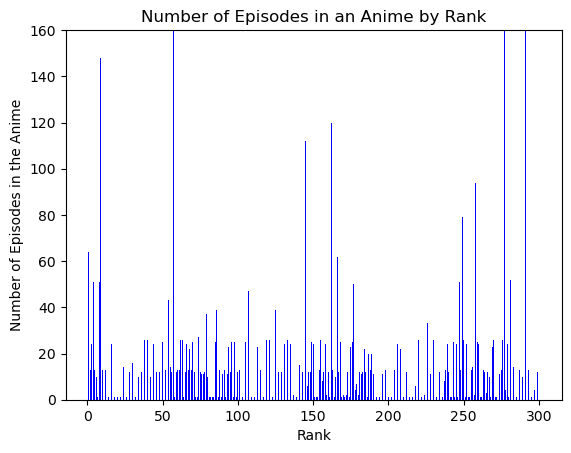

In [410]:
# Now plot our bar graph
plt.bar(rank, episodes, color ='Blue', width = 0.5)
plt.ylim(0, 160)

# Now add axis labels with units
plt.xlabel("Rank")
plt.ylabel("Number of Episodes in the Anime")

# We can add a title too
plt.title("Number of Episodes in an Anime by Rank")

episodes.describe()

From this bar chart, one thing that stook out to me was that there are a significant amount of anime movies (the shortest bar which is equivalent to one episode) in the top 300. However, most of the anime in the top 300 are, on average, either 12 or 24 episodes, with some outliers, such as the max value of 1049 being the anime One Piece, with its 1049 episodes.

# Test Code

After being reminded that I can scrape data using pandas.read_html, I wanted to make a solution utilizing this.

Unfortunately, a lot of the data was clumped together, so everything outside of rank, score, your score (N/A), and status (Add to List) was clumped together.

In order to properly add them to their own rows, I created empty lists that I would append the proper values to. At the end, I would add the columns with the list data, clean the data by removing the cluttered column, and concat it with the previous values.

As there is an extra row that is not needed, I droped the row, renamed the rank and score options, and fixed the index.

Then I created a final variable and called it to print out a table with all 300 values.

In [277]:
dates = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

combined_df = pd.DataFrame()

for c in range(0, 300, 50):
    dataframe = pd.read_html("https://myanimelist.net/topanime.php?limit=" + str(c))[0]
    df = pd.DataFrame(dataframe)
    del df[3]  # remove your score
    del df[4]  # remove status

    # Temp list for every category to be added to new row
    anime = ["Anime"]
    episodes = ["Episodes"]
    start_air_date = ["Start Air Date"]
    end_air_date = ["End Air Date"]
    members = ["Members"]
    
    # Fix section that has a conglomerate of data
    for d in range(1, len(dataframe)):
        split_data = df[1][d].split('  ')[:4]
        #print(split_data)
        anime.append(split_data[0])
        episodes.append(split_data[1])
        start_air_date.append(split_data[2].split(' - ')[0])
        if split_data[2].split(' - ')[1].split(' ')[1] == 'members':
            end_air_date.append('')
            members.append(split_data[2].split(' - ')[1])
        else:
            end_air_date.append(split_data[2].split(' - ')[1])
            members.append(split_data[3])

    # removes the blob and adds the temp categories to a new row
    del df[1]
    df.insert(1, 'Anime', anime)
    df.insert(2, 'Episodes', episodes)
    df.insert(3, 'Start Air Date', start_air_date)
    df.insert(4, 'End Air Date', end_air_date)
    df.insert(5, 'Members', members)
    
    #combines the current data with previous data
    combined_df = pd.concat([combined_df, df])

cdf = combined_df.drop([0])
cdf = cdf.rename(columns = {0: "Rank", 2: "Score"})
cdf = cdf.reset_index(drop=True)

cleaned_data = pd.DataFrame(cdf)
cleaned_data


,Rank,Anime,Episodes,Start Air Date,End Air Date,Members,Score
0,1,Fullmetal Alchemist: Brotherhood,TV (64 eps),Apr 2009,Jul 2010,"3,096,863 members",9.11
1,2,Bleach: Sennen Kessen-hen,TV (13 eps),Oct 2022,Dec 2022,"395,241 members",9.10
2,3,Steins;Gate,TV (24 eps),Apr 2011,Sep 2011,"2,385,156 members",9.08
3,4,GintamaÂ°,TV (51 eps),Apr 2015,Mar 2016,"579,580 members",9.07
4,5,Kaguya-sama wa Kokurasetai: Ultra Romantic,TV (13 eps),Apr 2022,Jun 2022,"762,610 members",9.07
...,...,...,...,...,...,...,...
295,296,Tonari no Totoro,Movie (1 eps),Apr 1988,Apr 1988,"984,593 members",8.25
296,297,Ginga Eiyuu Densetsu: Die Neue These - Seiran 3,Movie (4 eps),Nov 2019,Nov 2019,"23,569 members",8.25
297,298,Gyakkyou Burai Kaiji: Hakairoku-hen,TV (26 eps),Apr 2011,Sep 2011,"182,357 members",8.25
298,299,Danshi Koukousei no Nichijou,TV (12 eps),Jan 2012,Mar 2012,"778,157 members",8.24
